In [1]:
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt

from torch.utils.data import Dataset,DataLoader,sampler
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

In [2]:
# number of the total size of the data set
# this number is intentionally set to be small for the convenience of visualization
# feel free to try bigger ones, the results would be similar
N=40 
sigma=0.4 # sigma of the gaussian distribution, tweak this value to adjust the mixing level of the two classes

#label 0
l1=np.random.randn(2,N//2)*sigma+1
#label 1
l2=np.random.randn(2,N//2)*sigma

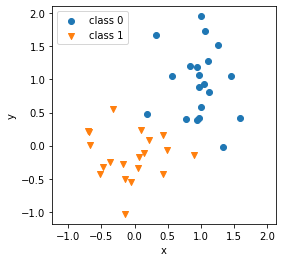

In [3]:
# visualize the data set
fig_dataset=plt.figure(figsize=(4,4))
plt.scatter(l1[0],l1[1],marker='o',label='class 0')
plt.scatter(l2[0],l2[1],marker='v',label='class 1')
plt.legend()
plt.xlabel('x')
plt.ylabel('y')
plt.axis('equal')
plt.show()

In [ ]:
# save figure if needed
fig_dataset.savefig('./fig_dataset.jpg')

In [4]:
# Dataset class for torch to work
class Dset(Dataset):
    def __init__(self,sample,label):
        super().__init__()
        self.sample=sample
        self.label=label
        
    def __getitem__(self,i):
        return self.sample[i],self.label[i]
    
    def __len__(self):
        return len(self.label)
    
    def __iter__(self):
        N=len(self)
        for i in range(N):
            yield self.sample[i],self.label[i]

In [5]:
dataset=Dset(torch.tensor(np.hstack([l1,l2]),dtype=torch.float32).T,
             torch.from_numpy(np.hstack([np.zeros((N//2,),dtype=np.int64),np.ones((N//2,),dtype=np.int32)])))
setloader=DataLoader(dataset,batch_size=10,sampler=sampler.SubsetRandomSampler(range(len(dataset))))

In [ ]:
###############################################
# Be CAREFUL of overwritting saved dataset!!!!#
###############################################

# save the data set
# torch.save(dataset,'./Torch_dataset.pkl')
# torch.save(setloader,'./Torch_loader.pkl')

# read the data set from save
dataset=torch.load('./Torch_dataset.pkl')
setloader=torch.load('./Torch_loader.pkl')

In [6]:
# generate a depth n NN classifier
def classifierNN(n):
    if (n>=2) and (n%2==0):
        dims=[2**(i+1) for i in range(n//2+1)]
        dims+=dims[0:-1][::-1]
    else:
        print('Input depth n should be even')
        return None
    layers=[]
    for t in range(len(dims)-1):
        i,o=dims[t:t+2]
        layers.append(nn.Linear(i,o))
        if not (t==len(dims)-2):
            layers.append(nn.ReLU())
    return nn.Sequential(*layers)

In [7]:
def train(model,loader,limit=1e-2,lr=1e-3,print_loss=False):
    opt=optim.Adam(model.parameters(),lr)
    l=0.70
    for e in range(1000):
        for sample,label in loader:
            opt.zero_grad()
            out=model(sample)
            loss=F.cross_entropy(out,label)
            loss.backward()
            l=l*0.9+loss.item()*0.1
            opt.step()
        if print_loss:
            print('loss=%.5f'%l)
        if l<=limit:
            print('Loss limit reached %.5f'%l)
            return True
            
    print('Loss limit not reached %.5f'%l)
    return False

In [19]:
depth=8
classifier=classifierNN(depth)

In [20]:
train(classifier,setloader)

Loss limit reached 0.00986


True

In [10]:
# calculate the softmax prediction value map in an area define by xp&yp
def p_map(xp,yp,model,label=0):
    nx=len(xp)
    ny=len(yp)
    gridpoints=torch.ones((ny,nx*2),dtype=torch.float32)
    gridpoints[:,0::2]*=xp.reshape(1,-1)
    gridpoints[:,1::2]*=yp.reshape(-1,1)
    gridlistview=gridpoints.view(-1,2)
    with torch.no_grad():
        l=F.softmax(model(gridlistview),dim=1)[:,label]
    return l.view(ny,nx)

In [11]:
nx=200
ny=200
x=np.linspace(-1,2.5,nx)
y=np.linspace(-1,2,ny)
p0=p_map(x,y,classifier).numpy()

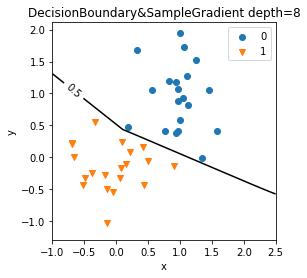

In [21]:
decision_boundary_fig=plt.figure(figsize=(4,4))
con=plt.contour(x,y,p0,[0.5],colors='black')
plt.clabel(con,inline=True,fontsize=10)
sc1=plt.scatter(l1[0],l1[1],label='0')
plt.scatter(l2[0],l2[1],marker='v',label='1')
plt.legend()
plt.xlabel('x')
plt.ylabel('y')
plt.axis('equal')
plt.title('DecisionBoundary&SampleGradient depth=%d'%depth)
plt.show()

In [22]:
# compute the sample gradient
grads=torch.zeros_like(dataset.sample)
for t,(s,l) in enumerate(dataset):
    s=s.clone().detach().requires_grad_(True)
    p=F.softmax(classifier(s),dim=0)[l]
    p.backward()
    grads[t]=-s.grad

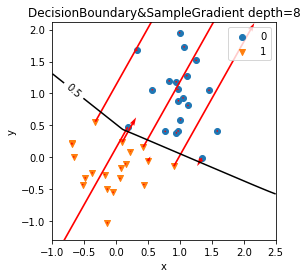

In [23]:
# visualize the sample gradient
samples=dataset.sample
x_=samples[:,0]
y_=samples[:,1]
u=grads[:,0]
v=grads[:,1]

ax=decision_boundary_fig.axes
ax[0].quiver(x_,y_,u,v,angles='xy',scale_units='xy',scale=0.5,color='r')
decision_boundary_fig